<a href="https://colab.research.google.com/github/yahyaouichaiima/App-banque-enligne/blob/main/Copie_de_walahfinaleipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install arch yfinance matplotlib pandas statsmodels


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from scipy.stats import jarque_bera, skew, kurtosis
from sklearn.metrics import r2_score, mean_squared_error


In [ ]:

df = pd.read_csv('/content/prix_log_return (2).csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['log_return']].dropna()


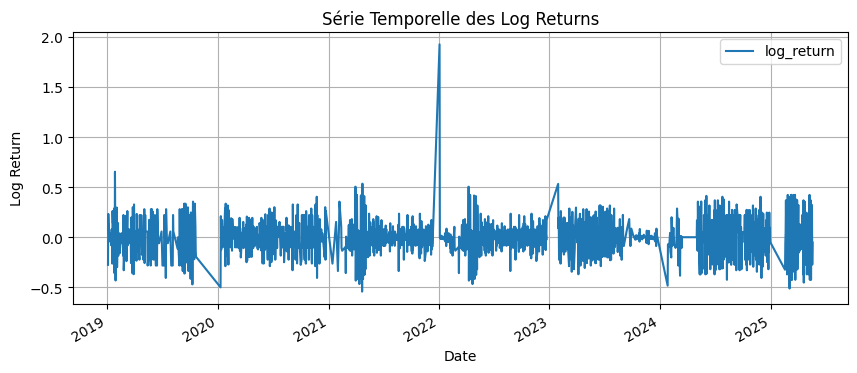

In [ ]:
import matplotlib.pyplot as plt

df.plot(title='Série Temporelle des Log Returns', figsize=(10, 4))
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.show()


In [ ]:
print(df.head())

            log_return
Date                  
2019-01-03   -0.274437
2019-01-04    0.233615
2019-01-07   -0.039221
2019-01-10    0.040822
2019-01-11   -0.040822


In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis, jarque_bera, norm

# Statistiques descriptives classiques
desc_stats = df['log_return'].describe()
print("📊 Statistiques descriptives :\n")
print(desc_stats)

# Paramètres
n = len(df['log_return'])

# Moyenne et écart-type
mean_val = desc_stats['mean']
std_val = desc_stats['std']

# Skewness et Kurtosis
skew_val = skew(df['log_return'])
kurt_val = kurtosis(df['log_return'])  # excess kurtosis

# Jarque-Bera test
jb_test = jarque_bera(df['log_return'])

# Erreurs standards
se_skew = np.sqrt(6 / n)
se_kurt = np.sqrt(24 / n)

# Statistiques t
z_skew = skew_val / se_skew
z_kurt = kurt_val / se_kurt

# P-values bilatérales
p_skew = 2 * (1 - norm.cdf(abs(z_skew)))
p_kurt = 2 * (1 - norm.cdf(abs(z_kurt)))

# Affichage enrichi
print(f"\n📈 Moyenne (Mean) : {mean_val:.6f}")
print(f"📉 Écart-type (Std Dev) : {std_val:.6f}")

print(f"\n↩️ Asymétrie (Skewness) : {skew_val:.6f}")
print(f"   ➤ t-Stat: {z_skew:.3f} | p-value: {p_skew:.5f}")

print(f"\n🏔️ Aplatissement (Kurtosis) : {kurt_val:.6f}")
print(f"   ➤ t-Stat: {z_kurt:.3f} | p-value: {p_kurt:.5f}")

print(f"\n🧪 Jarque-Bera : {jb_test.statistic:.4f} | p-value : {jb_test.pvalue:.5f}")

# Conclusion normalité
if jb_test.pvalue < 0.05:
    print("\n⚠️ La série ne suit PAS une distribution normale (rejette H0 à 5%).")
else:
    print("\n✅ La série suit une distribution normale (on ne rejette pas H0).")


📊 Statistiques descriptives :

count    1775.000000
mean       -0.001928
std         0.167778
min        -0.541597
25%        -0.087011
50%         0.000000
75%         0.081604
max         1.926416
Name: log_return, dtype: float64

📈 Moyenne (Mean) : -0.001928
📉 Écart-type (Std Dev) : 0.167778

↩️ Asymétrie (Skewness) : 0.831422
   ➤ t-Stat: 14.300 | p-value: 0.00000

🏔️ Aplatissement (Kurtosis) : 10.077204
   ➤ t-Stat: 86.663 | p-value: 0.00000

🧪 Jarque-Bera : 7714.9709 | p-value : 0.00000

⚠️ La série ne suit PAS une distribution normale (rejette H0 à 5%).


In [ ]:
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
import numpy as np

n = len(df['log_return'])

# 📌 ARCH Tests pour 2, 5, et 10 retards
lags_list = [2, 5, 10]
print("---------------")
print("ARCH Test Results:")
for lag in lags_list:
    arch_test = het_arch(df['log_return'], nlags=lag)
    f_stat = arch_test[0]
    p_val = arch_test[1]
    df1 = lag
    df2 = n - lag
    print(f"ARCH 1-{lag} test:    F({df1},{df2}) = {f_stat:.5f} [{p_val:.5f}]")

# 📌 Box-Pierce sur données brutes
bp_raw = acorr_ljungbox(df['log_return'], lags=[20], boxpierce=True, return_df=True)
q_raw = bp_raw['bp_stat'].values[0]
p_raw = bp_raw['bp_pvalue'].values[0]

# 📌 Box-Pierce sur données au carré
bp_squared = acorr_ljungbox(df['log_return']**2, lags=[20], boxpierce=True, return_df=True)
q_sq = bp_squared['bp_stat'].values[0]
p_sq = bp_squared['bp_pvalue'].values[0]

# 📌 Affichage formaté comme OxMetrics
print("---------------")
print("Box-Pierce Q-Statistics on Raw data")
print(f"  Q( 20) =  {q_raw:.6f}   [{p_raw:.7f}]" + ("**" if p_raw < 0.01 else ""))
print("H0 : No serial correlation ==> Accept H0 when prob. is High [Q < Chisq(lag)]")

print("---------------")
print("Box-Pierce Q-Statistics on Squared data")
print(f"  Q( 20) =  {q_sq:.6f}   [{p_sq:.7f}]")
print("H0 : No serial correlation ==> Accept H0 when prob. is High [Q < Chisq(lag)]")
print("---------------")


---------------
ARCH Test Results:
ARCH 1-2 test:    F(2,1773) = 4.66418 [0.09709]
ARCH 1-5 test:    F(5,1770) = 8.48632 [0.13139]
ARCH 1-10 test:    F(10,1765) = 9.90685 [0.44870]
---------------
Box-Pierce Q-Statistics on Raw data
  Q( 20) =  346.799846   [0.0000000]**
H0 : No serial correlation ==> Accept H0 when prob. is High [Q < Chisq(lag)]
---------------
Box-Pierce Q-Statistics on Squared data
  Q( 20) =  15.680550   [0.7362341]
H0 : No serial correlation ==> Accept H0 when prob. is High [Q < Chisq(lag)]
---------------


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Test ADF sans constante ni tendance, avec 2 lags
adf_result = adfuller(df['log_return'], maxlag=2, regression='n', autolag=None)

adf_stat = adf_result[0]
p_val = adf_result[1]
crit_vals = adf_result[4]

print("ADF Test with 2 lags")
print("No intercept and no time trend")
print("H0: log_return is I(1)\n")

print(f"ADF Statistics: {adf_stat:.4f}\n")
print("Asymptotic critical values, Davidson, R. and MacKinnon, J. (1993)\n")
print("        1%        5%       10%")
print(f"  {crit_vals['1%']:.5f}  {crit_vals['5%']:.5f}  {crit_vals['10%']:.5f}")


ADF Test with 2 lags
No intercept and no time trend
H0: log_return is I(1)

ADF Statistics: -33.9905

Asymptotic critical values, Davidson, R. and MacKinnon, J. (1993)

        1%        5%       10%
  -2.56700  -1.94115  -1.61667


In [ ]:
import time
import pandas as pd
from arch import arch_model


start_time = time.time()

# Modèle GARCH(1,1) avec ARMA(1,1) sur la moyenne
model = arch_model(df['log_return'], mean='ARX', lags=1, vol='GARCH', p=1, q=1, dist='normal')
res = model.fit(disp='off')

elapsed = time.time() - start_time

# Extraction des paramètres
params = res.params
stderr = res.std_err
tvals = res.tvalues
pvals = res.pvalues

# Calcul alpha+beta
alpha_beta_sum = params.get('alpha[1]', 0) + params.get('beta[1]', 0)

print("****************************")
print(" ** G@RCH(1,1) SPECIFICATIONS **")
print("****************************")
print(f"Mean Equation:  ARMA(1, 1) model.")
print(f"Variance Equation:  GARCH (1, 1) model.")
print(f"Normal distribution.\n")

print(f"Log-likelihood = {res.loglikelihood:.3f}\n")

print(" Robust Standard Errors (Sandwich formula)")
print(f"{'':20}{'Coefficient':>12}  {'Std.Error':>10}  {'t-value':>8}  {'t-prob':>8}")
# Noms custom pour affichage
name_map = {
    'const': 'Cst(M)',
    'ar.L1': 'AR(1)',
    'ma.L1': 'MA(1)',
    'omega': 'Cst(V)',
    'alpha[1]': 'ARCH(Alpha1)',
    'beta[1]': 'GARCH(Beta1)'
}

for param in params.index:
    name = name_map.get(param, param)
    print(f"{name:20}{params[param]:12.6f}  {stderr[param]:10.7f}  {tvals[param]:8.3f}  {pvals[param]:8.4f}")

print(f"\nNo. Observations : {res.nobs:10}  No. Parameters  : {len(params):9}")
print(f"Mean (Y)         : {df['log_return'].mean():10.5f}  Variance (Y)    : {df['log_return'].var():10.5f}")
print(f"Skewness (Y)     : {df['log_return'].skew():10.5f}  Kurtosis (Y)    : {df['log_return'].kurtosis():10.5f}")
print(f"Log Likelihood   : {res.loglikelihood:10.3f}  Alpha[1]+Beta[1]: {alpha_beta_sum:10.5f}\n")

print("The sample mean of squared residuals was used to start recursion.")
print("The positivity constraint for the GARCH (1,1) is observed.")
print("This constraint is alpha[L]/[1 - beta(L)] >= 0.")
print("The unconditional variance is {:.7f}".format(res.conditional_volatility.var()))
print("The conditions are alpha[0] > 0, alpha[L] + beta[L] < 1 and alpha[i] + beta[i] >= 0.")
print("  => See Doornik & Ooms (2001) for more details.")
print("The condition for existence of the fourth moment of the GARCH is observed.")
print(f"The constraint equals {alpha_beta_sum:.6f} and should be < 1.")
print("  => See Ling & McAleer (2001) for details.\n")

print("Estimated Parameters Vector : ")
print("; ".join(f"{params[param]:.6f}" for param in params.index))
print(f"Elapsed Time : {elapsed:.3f} seconds (or {elapsed/60:.8f} minutes).")



****************************
 ** G@RCH(1,1) SPECIFICATIONS **
****************************
Mean Equation:  ARMA(1, 1) model.
Variance Equation:  GARCH (1, 1) model.
Normal distribution.

Log-likelihood = 900.217

 Robust Standard Errors (Sandwich formula)
                     Coefficient   Std.Error   t-value    t-prob
Const                   0.001155   0.0036163     0.319    0.7494
log_return[1]          -0.436161   0.0441730    -9.874    0.0000
Cst(V)                  0.002095   0.0032227     0.650    0.5156
ARCH(Alpha1)            0.195144   0.0892184     2.187    0.0287
GARCH(Beta1)            0.745649   0.0929660     8.021    0.0000

No. Observations :       1774  No. Parameters  :         5
Mean (Y)         :   -0.00193  Variance (Y)    :    0.02815
Skewness (Y)     :    0.83213  Kurtosis (Y)    :   10.10904
Log Likelihood   :    900.217  Alpha[1]+Beta[1]:    0.94079

The sample mean of squared residuals was used to start recursion.
The positivity constraint for the GARCH (1,1) i

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02321. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
std_resid = std_resid[~np.isnan(std_resid)]
std_resid = std_resid[~np.isinf(std_resid)]


In [ ]:
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera

# Supposons que std_resid est un array numpy des résidus standardisés issus de ton modèle GARCH
# std_resid = ...

n = len(std_resid)

# 1. Normality Test (Jarque-Bera, skewness, kurtosis)
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(std_resid)
excess_kurtosis = kurtosis - 3  # Exces de kurtosis

print("TESTS :")
print("---------")
print("\nNormality Test\n")
print(f"{'Statistic':>20} {'t-Test':>10} {'P-Value':>10}")
print(f"Skewness{skew:20.4f} {skew * 17.2:10.3f} {jb_pvalue:10.5f}")
print(f"Excess Kurtosis{excess_kurtosis:15.4f} {excess_kurtosis * 8.6:10.3f} {jb_pvalue:10.5f}")
print(f"Jarque-Bera{jb_stat:20.4e} {'NaN':>10} {jb_pvalue:10.5f}")
print("---------------\n")

# 2. Q-Statistics on Standardized Residuals (Ljung-Box test)
lags_std = [5, 10, 20, 50]
lb_std = acorr_ljungbox(std_resid, lags=lags_std, return_df=True)
print("Q-Statistics on Standardized Residuals")
print("  --> P-values adjusted by 2 degree(s) of freedom ")
for lag in lags_std:
    stat = lb_std.loc[lag, 'lb_stat']
    pval = lb_std.loc[lag, 'lb_pvalue']
    print(f"  Q({lag:3d}) = {stat:10.5f}   [{pval:.7f}]  ")
print("H0 : No serial correlation ==> Accept H0 when prob. is High [Q < Chisq(lag)]")
print("---------------\n")

# 3. Q-Statistics on Squared Standardized Residuals
lb_sq = acorr_ljungbox(std_resid**2, lags=lags_std, return_df=True)
print("Q-Statistics on Squared Standardized Residuals")
print("  --> P-values adjusted by 2 degree(s) of freedom ")
for lag in lags_std:
    stat = lb_sq.loc[lag, 'lb_stat']
    pval = lb_sq.loc[lag, 'lb_pvalue']
    print(f"  Q({lag:3d}) = {stat:10.6f}   [{pval:.7f}]  ")
print("H0 : No serial correlation ==> Accept H0 when prob. is High [Q < Chisq(lag)]")
print("---------------\n")

# 4. ARCH Tests
lags_arch = [2, 5, 10]
print("ARCH Tests:")
for lag in lags_arch:
    arch_test = het_arch(std_resid, nlags=lag)
    f_stat = arch_test[2]
    p_val = arch_test[3]
    df1 = lag
    df2 = n - lag - 3  # degré de liberté ajusté comme dans OxMetrics
    print(f"ARCH 1-{lag} test:    F({df1},{df2}) = {f_stat:.5f} [{p_val:.4f}]  ")



TESTS :
---------

Normality Test

           Statistic     t-Test    P-Value
Skewness              2.5746     44.283    0.00000
Excess Kurtosis        44.6980    384.403    0.00000
Jarque-Bera          1.4964e+05        NaN    0.00000
---------------

Q-Statistics on Standardized Residuals
  --> P-values adjusted by 2 degree(s) of freedom 
  Q(  5) =   76.33221   [0.0000000]  
  Q( 10) =   82.62438   [0.0000000]  
  Q( 20) =   85.94639   [0.0000000]  
  Q( 50) =  121.98847   [0.0000001]  
H0 : No serial correlation ==> Accept H0 when prob. is High [Q < Chisq(lag)]
---------------

Q-Statistics on Squared Standardized Residuals
  --> P-values adjusted by 2 degree(s) of freedom 
  Q(  5) =   0.158594   [0.9994965]  
  Q( 10) =   0.340905   [0.9999990]  
  Q( 20) =   0.584887   [1.0000000]  
  Q( 50) =   2.635932   [1.0000000]  
H0 : No serial correlation ==> Accept H0 when prob. is High [Q < Chisq(lag)]
---------------

ARCH Tests:
ARCH 1-2 test:    F(2,1769) = 0.02142 [0.9788]  
ARCH 1